In [1]:
import pickle
import pandas as pd
import numpy as np

In [2]:
filename = 'data_baseline.pickle'
with open(filename, 'rb') as f:
    train,val, test = pickle.load(f)

In [3]:
train.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'BaseExcess',
       'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos',
       'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose',
       'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total',
       'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets',
       'Age', 'Gender', 'HospAdmTime', 'ICULOS', 'SepsisLabel', 'patient_id'],
      dtype='object')

In [8]:
train.shape

(554739, 39)

In [5]:
X_feature = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'BaseExcess',
       'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos',
       'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose',
       'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total',
       'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets',
       'Age', 'Gender', 'HospAdmTime', 'ICULOS']
y_feature = 'SepsisLabel'

In [6]:
X_train = train[X_feature]
y_train = train[y_feature]
X_val = val[X_feature]
y_val = val[y_feature]
X_test = test[X_feature]
y_test = test[y_feature]

In [7]:
# Reference
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=1211), max_features=37)
embeded_rf_selector.fit(X_train, y_train)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X_train.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')
display(embeded_rf_feature)

16 selected features


['HR',
 'Temp',
 'SBP',
 'PaCO2',
 'BUN',
 'Creatinine',
 'Glucose',
 'Potassium',
 'Hct',
 'Hgb',
 'PTT',
 'WBC',
 'Platelets',
 'Age',
 'HospAdmTime',
 'ICULOS']

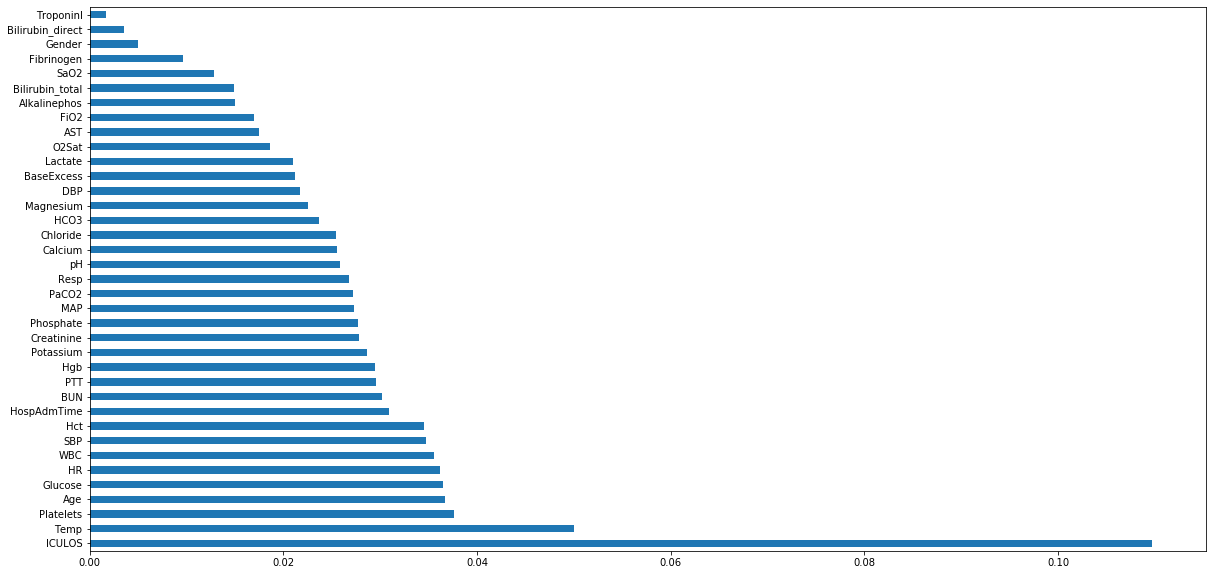

In [10]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
plt.figure(figsize=(20,10))

model = RandomForestClassifier(n_estimators=100, random_state=1211)
model.fit(X_train,y_train)
# print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(37).plot(kind='barh')
plt.show()

In [11]:
feat = feat_importances.sort_values(ascending=False).index
rf_feature = feat[:18]
rf_feature

Index(['ICULOS', 'Temp', 'Platelets', 'Age', 'Glucose', 'HR', 'WBC', 'SBP',
       'Hct', 'HospAdmTime', 'BUN', 'PTT', 'Hgb', 'Potassium', 'Creatinine',
       'Phosphate', 'MAP', 'PaCO2'],
      dtype='object')

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators':[50,100, 150], 'max_depth':[None, 10, 20, 30]}
rf = GridSearchCV(RandomForestClassifier(random_state=1211, oob_score=True, class_weight='balanced_subsample'), parameters, scoring='f1')
rf.fit(X_train,y_train)
print(rf.best_params_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_depth': 10, 'n_estimators': 150}


W/o feature selection

In [13]:
from sklearn.metrics import classification_report, auc, precision_recall_curve, roc_curve
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
best = RandomForestClassifier(random_state=1211, oob_score=True, max_depth=10, n_estimators=150, class_weight='balanced_subsample')
best.fit(X_train,y_train)

y_pred_best = best.predict(X_val)
y_pred_proba_best = best.predict_proba(X_val)[::,1]
precision_best, recall_best, thresholds_best = precision_recall_curve(y_val, y_pred_proba_best)
auc_best = auc(recall_best, precision_best)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba_best)
auroc = auc(fpr, tpr)

print(classification_report(y_val, y_pred_best))
print('F1 score:', f1_score(y_val,y_pred_best))
print('Precision:', precision_score(y_val,y_pred_best))
print('Recall:', recall_score(y_val,y_pred_best))
print('AUPRC:', auc_best)
print('AUC:', auroc)
print('Accuracy:', accuracy_score(y_val,y_pred_best))


              precision    recall  f1-score   support

           0       0.99      0.92      0.95    116372
           1       0.12      0.52      0.19      2501

    accuracy                           0.91    118873
   macro avg       0.55      0.72      0.57    118873
weighted avg       0.97      0.91      0.94    118873

F1 score: 0.1920529801324503
Precision: 0.11768419154116692
Recall: 0.5217912834866053
AUPRC: 0.12067391262045657
AUC: 0.8264378691516554
Accuracy: 0.9076325153735499


Text(0.5, 1.0, 'Precision-Recall Curve For Baseline w/o Feature Selection')

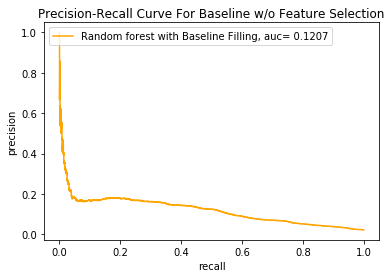

In [14]:
from matplotlib import pyplot as plt
plt.plot(recall_best,precision_best,color = 'orange', label="Random forest with Baseline Filling, auc= %.4f" %auc_best)

plt.xlabel('recall')
plt.ylabel('precision')
plt.legend(loc = 2)
plt.title('Precision-Recall Curve For Baseline w/o Feature Selection')

In [16]:
! pip install plot_metric

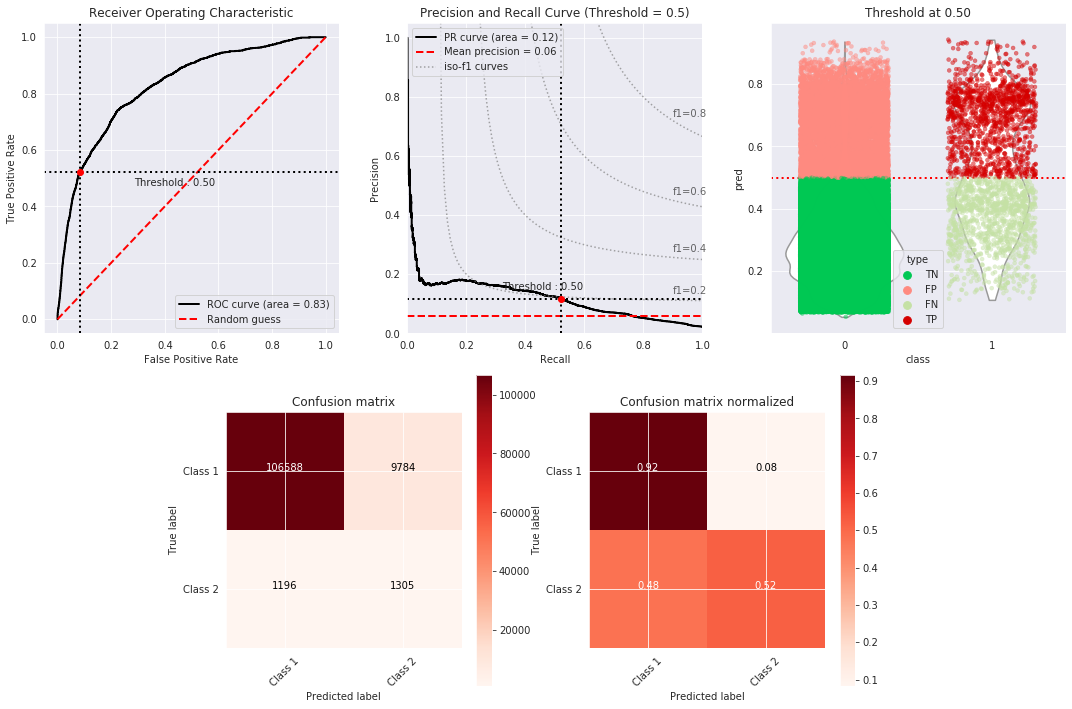

                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
              precision    recall  f1-score   support

     Class 1       0.99      0.92      0.95    116372
     Class 2       0.12      0.52      0.19      2501

    accuracy                           0.91    118873
   macro avg       0.55      0.72      0.57    118873
weighted avg       0.97      0.91      0.94    118873



In [17]:
from plot_metric.functions import BinaryClassification
bc = BinaryClassification(y_val,y_pred_proba_best, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(15,10))
plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
bc.plot_roc_curve()
plt.subplot2grid((2,6), (0,2), colspan=2)
bc.plot_precision_recall_curve()
plt.subplot2grid((2,6), (0,4), colspan=2)
bc.plot_class_distribution()
plt.subplot2grid((2,6), (1,1), colspan=2)
bc.plot_confusion_matrix()
plt.subplot2grid((2,6), (1,3), colspan=2)
bc.plot_confusion_matrix(normalize=True)
plt.show()
bc.print_report()

With feature selection

In [0]:
X_train_fs = train[embeded_rf_feature]
X_val_fs = val[embeded_rf_feature]

In [19]:
best = RandomForestClassifier(random_state=1211, oob_score=True, max_depth=10, n_estimators=150, class_weight='balanced_subsample')
best.fit(X_train_fs,y_train)

y_pred_best = best.predict(X_val_fs)
y_pred_proba_best = best.predict_proba(X_val_fs)[::,1]
precision_best, recall_best, thresholds_best = precision_recall_curve(y_val, y_pred_proba_best)
auc_best = auc(recall_best, precision_best)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba_best)
auroc = auc(fpr, tpr)

print(classification_report(y_val, y_pred_best))
print('F1 score:', f1_score(y_val,y_pred_best))
print('Precision:', precision_score(y_val,y_pred_best))
print('Recall:', recall_score(y_val,y_pred_best))
print('AUPRC:', auc_best)
print('AUC:', auroc)
print('Accuracy:', accuracy_score(y_val,y_pred_best))

              precision    recall  f1-score   support

           0       0.99      0.92      0.95    116372
           1       0.12      0.51      0.19      2501

    accuracy                           0.91    118873
   macro avg       0.55      0.71      0.57    118873
weighted avg       0.97      0.91      0.93    118873

F1 score: 0.1888847994111152
Precision: 0.11575243594370263
Recall: 0.5129948020791684
AUPRC: 0.11899075921223842
AUC: 0.8210680186729833
Accuracy: 0.9073044341440024


Text(0.5, 1.0, 'Precision-Recall Curve For Baseline w/ Feature Selection')

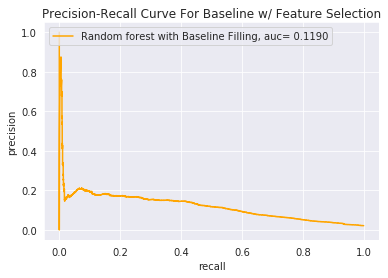

In [20]:
plt.plot(recall_best,precision_best,color = 'orange', label="Random forest with Baseline Filling, auc= %.4f" %auc_best)

plt.xlabel('recall')
plt.ylabel('precision')
plt.legend(loc = 2)
plt.title('Precision-Recall Curve For Baseline w/ Feature Selection')

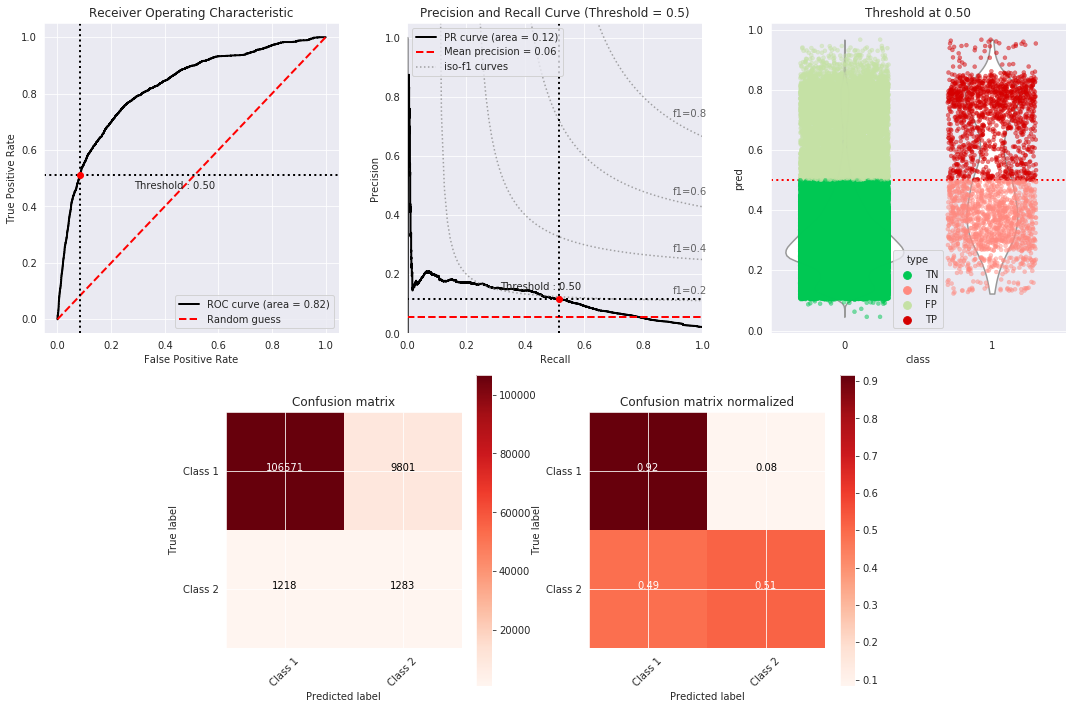

                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
              precision    recall  f1-score   support

     Class 1       0.99      0.92      0.95    116372
     Class 2       0.12      0.51      0.19      2501

    accuracy                           0.91    118873
   macro avg       0.55      0.71      0.57    118873
weighted avg       0.97      0.91      0.93    118873



In [21]:
from plot_metric.functions import BinaryClassification
bc = BinaryClassification(y_val, y_pred_proba_best, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(15,10))
plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
bc.plot_roc_curve()
plt.subplot2grid((2,6), (0,2), colspan=2)
bc.plot_precision_recall_curve()
plt.subplot2grid((2,6), (0,4), colspan=2)
bc.plot_class_distribution()
plt.subplot2grid((2,6), (1,1), colspan=2)
bc.plot_confusion_matrix()
plt.subplot2grid((2,6), (1,3), colspan=2)
bc.plot_confusion_matrix(normalize=True)
plt.show()
bc.print_report()

# Best model on test 

In [0]:
X_train_fs = train[embeded_rf_feature]
X_test_fs = test[embeded_rf_feature]

In [23]:
from sklearn.metrics import classification_report, auc, precision_recall_curve, roc_curve
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

best = RandomForestClassifier(random_state=1211, oob_score=True, max_depth=10, n_estimators=150, class_weight='balanced_subsample')
best.fit(X_train_fs,y_train)

y_pred_best = best.predict(X_test_fs)
y_pred_proba_best = best.predict_proba(X_test_fs)[::,1]
precision_best, recall_best, thresholds_best = precision_recall_curve(y_test, y_pred_proba_best)
auc_best = auc(recall_best, precision_best)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_best)
auroc = auc(fpr, tpr)

print(classification_report(y_test, y_pred_best))
print('F1 score:', f1_score(y_test,y_pred_best))
print('Precision:', precision_score(y_test,y_pred_best))
print('Recall:', recall_score(y_test,y_pred_best))
print('AUPRC:', auc_best)
print('AUC:', auroc)
print('Accuracy:', accuracy_score(y_test,y_pred_best))

              precision    recall  f1-score   support

           0       0.99      0.92      0.95    115737
           1       0.12      0.53      0.20      2502

    accuracy                           0.91    118239
   macro avg       0.56      0.72      0.58    118239
weighted avg       0.97      0.91      0.94    118239

F1 score: 0.19951668932185473
Precision: 0.12299813780260707
Recall: 0.5279776179056754
AUPRC: 0.12824719300702297
AUC: 0.8183374155717461
Accuracy: 0.9103510685983475


Text(0.5, 1.0, 'Precision-Recall Curve For on Test by Best Baseline')

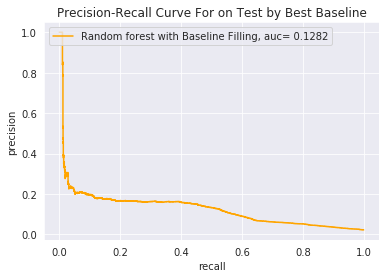

In [24]:
plt.plot(recall_best,precision_best,color = 'orange', label="Random forest with Baseline Filling, auc= %.4f" %auc_best)

plt.xlabel('recall')
plt.ylabel('precision')
plt.legend(loc = 2)
plt.title('Precision-Recall Curve For on Test by Best Baseline')

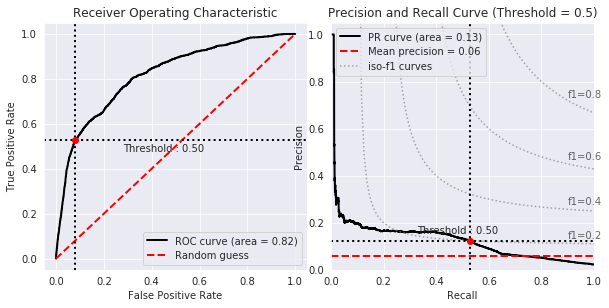

In [27]:
from plot_metric.functions import BinaryClassification
bc = BinaryClassification(y_test,y_pred_proba_best, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(15,10))
plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
bc.plot_roc_curve()
plt.subplot2grid((2,6), (0,2), colspan=2)
bc.plot_precision_recall_curve()
# plt.subplot2grid((2,6), (0,4), colspan=2)
# bc.plot_class_distribution()
# plt.subplot2grid((2,6), (1,1), colspan=2)
# bc.plot_confusion_matrix()
# plt.subplot2grid((2,6), (1,3), colspan=2)
# bc.plot_confusion_matrix(normalize=True)
plt.show()
# bc.print_report()

In [1]:
def F(beta, precision, recall):
    return (beta*beta + 1)*precision*recall / (beta*beta*precision + recall)

In [2]:
F(1,0.21,0.53)

0.3008108108108108